In [1]:
# # Find TE20 mode and LN waveguide validation 
# # LN Straight Waveguide Simulation

# ## 1. Simulation Environment
import numpy as np
import meep as mp
import autograd.numpy as npa
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import nlopt
#from meep.materials import LiNbO3 (unit=um)

resolution = 50
################################## Meep mpb(eigen mode solver 에서 x symmetry를 미지원 -> xy 평면 rotate)

flux_normalization = 1 # 1: on, else: off 
capture_setup = 1 # 1: on, else: off
capture_fields = 1 # 1: on, else: off

# In[4]:
Lpml= 20.0/ resolution

Sx= 2.0# 높이: 위아래 pml 0부터 LN, 그아래는 SiO2
Sy= 3.0# 너비: 좌우 pml, 폭 3um                         -|-
Sz= 20.0# 길이 (진행방향): 3 

#Air= mp.Medium(index=1.0)
SiO2= mp.Medium(index=1.45)# Back ground material
My_LiNbO3= mp.Medium(epsilon_diag=mp.Vector3(4.88542609, 4.58345281, 4.88542609)) # X cut
# pml 두께 여기서 들어감.
cell= mp.Vector3(Sx+ 2*Lpml, Sy+ 2*Lpml, Sz+ 2*Lpml)

# 공간 비례 변수 (pml 뺀 유효 공간)
X_min= 0.5*-Sx
Y_min= 0.5*-Sy
Z_min= 0.5*-Sz

X_max= 0.5*Sx
Y_max= 0.5*Sy
Z_max= 0.5*Sz

# 높이 (x: thickness)
LNsub_h= 0.1 # LN substrate
SiO2_h= 1.0 # SiO2 substrate
LNwg_h= 0.5 # LN waveguide

# 폭 (y: width)
min_g= 0.424 # minimum gap
w_top= 0.798 # top width (output waveguide)
w_bot= w_top+ min_g #bottom width (1222 nm) 

# y-x plane 전체 = 모니터
Target_size = mp.Vector3(Sx, Sy, 0)

# 구조물 
geometry= [
    # mp.Block(#SiO2 substrate
    #     center= mp.Vector3(X_min+ 0.5*SiO2_h, 0, 0+ Lpml/2),
    #     material= SiO2,
    #     size= mp.Vector3(SiO2_h, Sy, Sz+ Lpml)
    # ),
    mp.Block(#LiNbO3 substrate
        center= mp.Vector3(X_min+ SiO2_h+ 0.5*LNsub_h, 0, 0+ Lpml/2),
        material= My_LiNbO3,
        size= mp.Vector3(LNsub_h, Sy, Sz+ Lpml)
    ),    
    mp.Prism(#LiNbO3 waveguide
        vertices = [
            mp.Vector3(X_min+ SiO2_h+ LNsub_h, w_bot/2, Z_min),
            mp.Vector3(X_min+ SiO2_h+ LNsub_h, -w_bot/2, Z_min),
            mp.Vector3(X_min+ SiO2_h+ LNsub_h+ LNwg_h, -w_top/2, Z_min),
            mp.Vector3(X_min+ SiO2_h+ LNsub_h+ LNwg_h, w_top/2, Z_min)
        ],
        height= Sz+Lpml,
        axis= mp.Vector3(0, 0, 1),
        sidewall_angle= 0,
        material= My_LiNbO3,
    )
]

fcen= 1.0/ 1.55 # 775 nm
fwidth = 0.1 * fcen
####
source_center = mp.Vector3(X_min+ SiO2_h+ (LNsub_h+ LNwg_h)/2, 0, Z_min+ 1)
source_size = mp.Vector3(LNsub_h+ LNwg_h+ 0.4, 2.0, 0) # 1X2
####
kpoint = mp.Vector3(0,0,1)
src = mp.GaussianSource(frequency= fcen, fwidth= fwidth)#, is_integrated=True)

source1 = [
    mp.EigenModeSource(
        src,
        size= source_size,
        center= source_center,
        direction= mp.NO_DIRECTION,
        eig_kpoint= kpoint,
        eig_band= 8,
        eig_parity=mp.NO_PARITY,
        eig_match_freq= True,
    ),
]

pml_layers = [mp.PML(thickness=Lpml)]#, direction=mp.Y)]

sim = mp.Simulation(
    cell_size= cell,
    resolution= resolution,
    boundary_layers= pml_layers,
    sources= source1,
    eps_averaging= False,
    geometry= geometry,
    default_material=SiO2, # 이거 Air vs LiNbO3
    #symmetries=[mp.Mirror(mp.Y)],
)

T_center= mp.Vector3(X_min+ SiO2_h+ (LNsub_h+ LNwg_h)/2, 0, Z_max- 1)
T_center_tot= mp.Vector3(X_min+ SiO2_h+ (LNsub_h+ LNwg_h)/2, 0, Z_min+ 3)
T_size = mp.Vector3(LNsub_h+ LNwg_h+ 0.4, 1.8, 0) # 1X2

# transmitted flux
tran_fr = mp.FluxRegion(center= T_center, size= T_size)
tran = sim.add_flux(fcen, fwidth, 1, tran_fr)

if flux_normalization == 1: # T, R monitor for normalization
    tran_tot = mp.FluxRegion(center= T_center_tot, size= T_size)
    Tt = sim.add_flux(fcen, fwidth, 1, tran_tot)

if capture_setup == 1: # simulation setup capture
    plt.figure()
    sim.plot2D(output_plane = mp.Volume(center=source_center, size = mp.Vector3(mp.inf, mp.inf, 0)))
    plt.savefig("LN_waveguide_xy_plane.png")
    plt.cla()
    plt.clf()
    plt.close()

    plt.figure()
    sim.plot2D(output_plane = mp.Volume(center=(X_min+ SiO2_h+ LNsub_h, 0, 0), size = mp.Vector3(0, Sy+ 2*Lpml, mp.inf)))
    plt.savefig("LN_waveguide_yz_plane.png")
    plt.cla()
    plt.clf()
    plt.close()

    plt.figure()
    sim.plot2D(output_plane = mp.Volume(center=(0, 0, 0), size = mp.Vector3(mp.inf, 0, mp.inf)))
    plt.savefig("LN_waveguide_xz_plane.png")
    plt.cla()
    plt.clf()
    plt.close()

Input_Ex=[0]*100
Input_Ey=[0]*100
Input_Ez=[0]*100


for i in range(0,100): # Z=source to Z=Sz-1, 100EA

    Target_center=mp.Vector3(X_min+ SiO2_h+ LNsub_h+ LNwg_h/2, 0, Z_min+ 1+ i*(Sz-1.0)/100)

    Input_Ex[i]=sim.add_dft_fields(
        [mp.Ex],
        fcen,
        0,
        1,
        center=Target_center,
        size = Target_size,
    )
    Input_Ey[i]=sim.add_dft_fields(
        [mp.Ey],
        fcen,
        0,
        1,
        center=Target_center,
        size = Target_size,
    ) 

    Input_Ez[i]=sim.add_dft_fields(
        [mp.Ez],
        fcen,
        0,
        1,
        center=Target_center,
        size = Target_size,
    ) 

     block, center = (0.05,0,0.2)
          size (0.1,3,20.4)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)
     prism, center = (0.35,0,0.2)
          height 20.4, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0.1,0.611,-10)
          (0.1,-0.611,-10)
          (0.6,-0.399,-10)
          (0.6,0.399,-10)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)
     block, center = (0.05,0,0.2)
          size (0.1,3,20.4)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)
     prism, center = (0.35,0,0.2)
          height 20.4, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0.1,0.611,-10)
          (0.1,-0.611,-10)
          (0.6,-0.399,-10)
          (0.6,0.399,-10)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0.05,0,0.2)
          size (0.1,3,20.4)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)
     prism, center = (0.35,0,0.2)
          height 20.4, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0.1,0.611,-10)
          (0.1,-0.611,-10)
          (0.6,-0.399,-10)
          (0.6,0.399,-10)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)


In [2]:
n = np.sqrt(My_LiNbO3.epsilon(freq)[0,0])
n_meep = []
resolution1=50
sim.init_sim()
Target_size = mp.Vector3(Sx, Sy, 0)
for i in range(0,3):
    Target_center=mp.Vector3(X_min+ SiO2_h+ LNsub_h+ LNwg_h/2, 0, Z_min+ 1+ i*(Sz-1.0)/100)
    where = mp.Volume(center= Target_center, size= Target_size)
    direction = mp.Z
    band_num = 8
    kpoint = mp.Vector3(0,0,1)
    ed = sim.get_eigenmode(fcen, direction, where, band_num, kpoint, eig_vol=None, match_frequency=True, 
    parity=mp.NO_PARITY, resolution=resolution1, eigensolver_tol=1e-16)

    k = ed.k
    # k = k.x + k.y + k.z
    n_meep.append(k.z/fcen)
print(n_meep)

-----------
Initializing structure...
time for choose_chunkdivision = 0.0010221 s
Working in 3D dimensions.
Computational cell is 2.8 x 3.8 x 20.8 with resolution 50
     block, center = (0.05,0,0.2)
          size (0.1,3,20.4)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)
     prism, center = (0.35,0,0.2)
          height 20.4, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0.1,0.611,-10)
          (0.1,-0.611,-10)
          (0.6,-0.399,-10)
          (0.6,0.399,-10)
          dielectric constant epsilon diagonal = (4.88543,4.58345,4.88543)
time for set_epsilon = 14.6857 s
-----------
MPB solved for frequency_8(0,0,1) = 0.761123 after 53 iters
MPB solved for frequency_8(0,0,0.67898) = 0.647068 after 28 iters
MPB solved for frequency_8(0,0,0.673402) = 0.645164 after 19 iters
MPB solved for frequency_8(0,0,0.673395) = 0.645161 after 3 iters
MPB solved for frequency_8(0,0,1) = 0.701718 after 100 iters


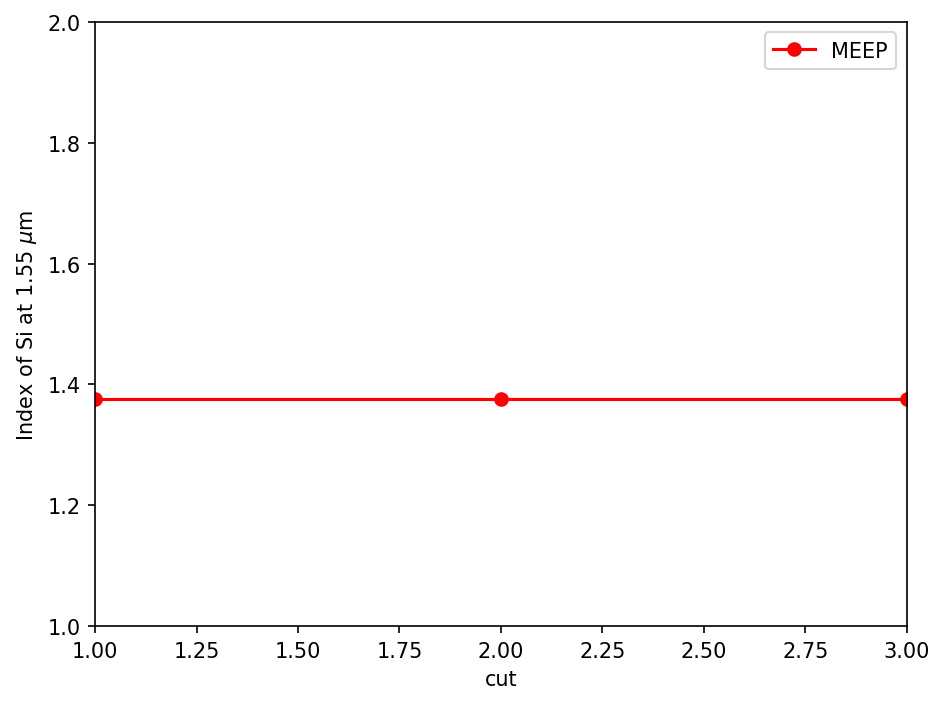

In [30]:
# n = np.sqrt(My_LiNbO3.epsilon(fcen)[0,0])
xaxis = np.linspace(1,3,3)
plt.figure(dpi=150)
# plt.hlines(n,min(res),max(res),label='Si',color='blue',linewidth=2)
plt.plot(xaxis,n_meep,'-o',label='MEEP',color='red')
# plt.plot(res,n_mpb,'--o',label='MPB',color='green',linewidth=2)
plt.legend()
plt.grid(False)
plt.axis([1.0, 3.0, 1, 2])
plt.ylabel('Index of Si at {} $\mu$m'.format(1/fcen))
plt.xlabel('cut')
plt.tight_layout()
plt.savefig('meep_mpb_comparison.png')
plt.show()

In [22]:
print(n_meep)

[1.3754261633363507, 1.375426163336353, 1.3754261633363523]
